## Spherical Splines based on Jupp & Kent (1987)

This notebook implements the algorithm for fitting splines introdiced in [Fitting Smooth Paths to Spherical Data](https://www.jstor.org/stable/2347843). The same implements a series of projections of spherical data to the 2D plane and then applies splines fit there. 

In [1]:
import pandas as pd
import numpy as np
import os
import cartopy.crs as ccrs
import pmagpy.ipmag as ipmag

from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 20)

from utils.geometry import cartesian2spherical, spherical2cartesian

As an example, we are going to use the same example the authors use in the paper. Something that is not clear is what to do with points with same age. Traditional splines methods don't allow to use more than one data point per same age/dependent variable. 

In [21]:
df = pd.read_csv('data/df_pole_compilation_by_study.csv', encoding="cp1254")
df['Time'] = df['mean_age']
df['Lat'] = - df['Plat'] # reverse latitude to coincide with north pole following the defaul to Jupp
df['Lon'] = df['Plon']
df = df[['Time', "Lat", 'Lon']]
#df.loc[df.shape[0]] = [0, 90., 0]
df

,Time,Lat,Lon
0,49.5000,81.917678,328.575930
1,42.0000,79.313242,327.669841
2,55.8885,81.549042,2.761738
3,0.7670,80.164116,314.290252
4,50.9500,72.178647,344.432968
5,2.2550,88.503095,154.996894
6,1.1050,84.889461,298.871431
7,1.0700,73.775957,249.302652
8,22.6500,83.335839,324.273564
9,8.2350,88.340153,267.711248


In [22]:
#df = pd.read_csv('data/Jupp-etal-1987_dataset.csv', encoding="cp1254")
# We also manually add a fixed point in the origin of coordinates 
#df.loc[df.shape[0]] = ['Origin', 0, 90., 0]
#df.at[24, 'Time'] = 470.0

# In order to do splines, we need the time coordinate to be strictly increasing. This is a little bit annoying, so for now
# we replace poles with same age by picking the first one in the age
df = df.groupby(['Time']).first().reset_index()

#df['Lat'] = 90 - df['Time'] * 0.1
#df['Lon'] = df['Time'] * 0.5 

# Add cartesian coordinates
df['x'] = df.apply(lambda row: spherical2cartesian([np.radians(row["Lat"]), np.radians(row.Lon)])[0], axis=1) 
df['y'] = df.apply(lambda row: spherical2cartesian([np.radians(row["Lat"]), np.radians(row.Lon)])[1], axis=1) 
df['z'] = df.apply(lambda row: spherical2cartesian([np.radians(row["Lat"]), np.radians(row.Lon)])[2], axis=1) 

df = df.sort_values(by='Time')
# Filter the last points that for some reason are crashing the method
#df = df[df['Time'] < 400]
df

,Time,Lat,Lon,x,y,z
0,0.3555,83.095837,42.690352,0.088357,0.081506,0.992749
1,0.3870,87.664063,11.142714,0.039990,0.007877,0.999169
2,0.7635,85.421918,263.872370,-0.008520,-0.079362,0.996809
3,0.7670,80.164116,314.290252,0.119287,-0.122280,0.985301
4,1.0700,73.775957,249.302652,-0.098747,-0.261362,0.960177
5,1.1050,84.889461,298.871431,0.043011,-0.078006,0.996025
6,1.8950,87.135817,218.526712,-0.039091,-0.031124,0.998751
7,2.0550,80.838128,336.592990,0.146121,-0.063253,0.987242
8,2.2550,88.503095,154.996894,-0.023675,0.011041,0.999659
9,3.0140,86.874229,187.769496,-0.054027,-0.007372,0.998512


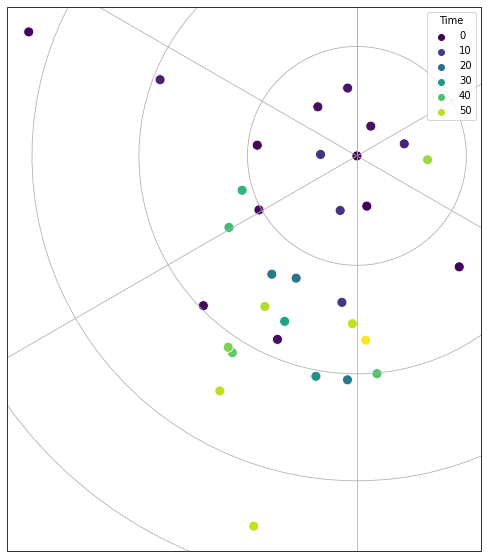

In [4]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=90))

#ax.coastlines()
ax.gridlines()

sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=100,
                palette="viridis",
                transform = ccrs.PlateCarree());

## Setup



In [5]:
from typing import NamedTuple

class Params(NamedTuple):
    
    lamb : float    
    delta : float 
    
params = Params(lamb = 4*10e4,
                delta = .1)

In [6]:
def slerp_interpolation(p1, p2, t, order, tmin=None, tmax=None):
    '''
    Returns the Slerp interpolation between two unitary vectors on the 3D sphere following a great circle
    '''
    angle = np.arccos(np.dot(p1,p2))

    if order == 0:
        return ( np.sin((1-t)*angle) * p1 + np.sin(t*angle) * p2 ) / np.sin(angle)
    elif order == 1:
        return angle * ( np.cos(t*angle) * p2 - np.cos((1-t)*angle) * p1 ) / (np.sin(angle) * (tmax-tmin)) 
    else:
        raise ValueError('Order derivative not implemented.')
        
        
def cart2sph(X, radians=True):
    '''
    X : (N,3) numpy array
    '''
    Y = np.zeros((X.shape[0], 2))
    Y[:,0] = np.arctan2(X[:,1], X[:,0])   # Longitude
    Y[:,1] = np.arcsin(X[:,2])            # Latitude
    #Y[:,1] = np.arccos(X[:,2])           # Colatitude

    if not radians:
        Y *= 180. / np.pi
    
    return Y

In [7]:
class S2Curve:
    '''
    Curve clase we are going to fit in the sphere.
    This will be consist in a series of timesteps where we can exactly evaluate the curve. For all the intermediate steps, we use the 
    great circle between adjacent knots to evalaute the function 
    '''
    
    def __init__(self, time_values, knot_values):
        
        self.time_values = time_values
        self.knot_values = knot_values
        self.planar_values = None
        self.Rotations = None
    
    #time_values : np.ndarray   # (N,) 
    #knot_values : np.ndarray   # (N,3) 
    #planar_values : np.ndarray # (N,2) 
    #Rotations : np.ndarray     # (N,3,3)
    
    def evaluate(self, t, order=0):
        """
        Return evaluation of the curve
        
        Parameters:
        - order: order correspondint to the evaluation of the derivative. If equals to 0 this is just the evaluation of the function. 
        
        """
        assert (np.min(self.time_values) <= t) & (t <= np.max(self.time_values)), 'Age value is not inside the evaluation window.'
        # this is a comment
        idx_inf = np.max(np.where(self.time_values - t <= 0.0))
        idx_sup = np.min(np.where(self.time_values - t >= 0.0))

        if idx_inf == idx_sup and order == 0:
            #print('Evaluating self node.')
            return self.knot_values[idx_inf, :]
        elif idx_inf == idx_sup and order > 0:
            idx_sup += 1
        assert idx_inf + 1 == idx_sup
        
        time_inf = self.time_values[idx_inf]
        time_sup = self.time_values[idx_sup]
        incremental = (t - time_inf) / (time_sup - time_inf)
        assert 0 <= incremental <= 1
        
        knot_inf = self.knot_values[idx_inf, :]
        knot_sup = self.knot_values[idx_sup, :]

        return slerp_interpolation(knot_inf, knot_sup, incremental, order=order, tmin=time_inf, tmax=time_sup)

    def update_rotation(self, R):
        self.Rotations = R
        
    def update_unroll(self, unrolled):
        self.planar_values = unrolled
    
    def plot(self):
        plt.figure(figsize=(15,8))
        ax1 = plt.subplot2grid((2,2), (0,0), rowspan=2, projection=ccrs.Orthographic(central_latitude=90))
        ax2 = plt.subplot2grid((2,2), (0,1))
        ax3 = plt.subplot2grid((2,2), (1,1))
        
        ax1.gridlines()
        
        knot_values_sph = cart2sph(self.knot_values, radians=False) 
        
        sns.scatterplot(ax=ax1, x = knot_values_sph[:,0], y = knot_values_sph[:,1], 
                        hue = self.time_values,
                        transform = ccrs.PlateCarree())
        
        ax2.plot(self.time_values,  knot_values_sph[:,0], 'o-', ms=1, c='red')
        ax3.plot(self.time_values,  knot_values_sph[:,1], 'o-', ms=1)

## Unrolling the curve

Unrolling the curve $f: [0, T] \mapsto S^2$ requires to solve a set of differntial equation for both $f(t)$ and the rotation matrix $R(t)$, defined as 
$$
R(t)f(t) = (0,0,1).
$$
The differential equations are
$$
\frac{d}{dt}f^*(t) = R(t) f(t)
$$
and 
$$
R(t)^T R'(t) = M( f'(t) \times f(t))
$$
with initial conditions 
$$
f^*(0) = 0 \qquad R(0)f'(0) = (\| f'(0) \|,0,0)
$$

In [8]:
from scipy.spatial.transform import Rotation as Rotation_operator

def skew_matrix(v):
    skv = np.roll(np.roll(np.diag(v.flatten()), 1, 1), -1, 0)
    return skv - skv.T

def unroll_curve(curve, delta_t=0.1):
    '''
    Unroll one single curve f to f* following the Appendix in Jupp et. al. (1987)
    
    Given a Curve() object, we return the 
    '''    
    N = curve.time_values.shape[0]
    
    f_star = np.zeros((N,3))    # We leave the third coordinate always equal to zero for simplicity
    Rotation = np.zeros((N,3,3))
    
    # Initial Conditions
    # We need to find a rotation R0 such that it satisfies the conditions R0 * f(0) = (0,0,1) and R0 * f'(0) = (c,0,0)
    # First we find a rotation R1 such that R1 * f(0) = (0,0,1)
    
    t0 = curve.time_values[0]
    f0 = curve.evaluate(t0, order=0)
    
    if np.linalg.norm(f0 - [0,0,1]) < 0.0001:
        R1 = Rotation_operator.from_rotvec([0,0,0])
    else:
        angle = np.arccos(np.dot(f0, [0,0,1]))
        rotation_axis = np.cross(f0, [0,0,1])
        rotation_axis /= np.linalg.norm(rotation_axis)
        R1 = Rotation_operator.from_rotvec(angle * rotation_axis)
    
    # and now we define a second rotation with axis (0,0,1) that rotates f'(0) to the x-axis  
    f_derivative = curve.evaluate(t0, order=1)
    f_derivative_rotated = R1.apply(f_derivative)
    f_derivative_rotated_normalized = f_derivative_rotated / np.linalg.norm(f_derivative_rotated)
    
    assert np.abs(f_derivative_rotated_normalized[2]) < 0.0001, 'After rotation, the gradient is not paralel to (0,0,1). Instead it gives {}'.format(f_derivative_rotated_normalized)
    angle = np.arccos(np.dot(f_derivative_rotated_normalized, [1,0,0]))
    rotation_axis = np.cross(f_derivative_rotated_normalized, [1,0,0])
    rotation_axis /= np.linalg.norm(rotation_axis)
    # We do this because the angle is not enough to know the direction of rotation
    
    assert np.abs(rotation_axis[2]) > 0.99, "Rotation axis is {}".format(rotation_axis)
    R2 = Rotation_operator.from_rotvec(angle * rotation_axis)
    
    # Composition of rotations
    R = R2 * R1
    
    assert np.linalg.norm(R.apply(f0) - [0,0,1]) < 0.001
    f_derivative_normalized = f_derivative / np.linalg.norm(f_derivative)
    assert np.linalg.norm(R.apply(f_derivative_normalized) - [1,0,0]) < 0.001, 'The obtained initial rotation R(0) does not satisfy R(0)df(0)=[c,0,0]. Instead, the rotation gives {}'.format(R.apply(f_derivative_rotated_normalized))
    
    f_star[0,:] = [0,0,0]
    Rotation[0,:,:] = R.as_matrix()
    
    f_ = f_star[0,:]
    R = Rotation[0,:,:]
    
    # Iterative steps
    
    for idx in range(len(curve.time_values)-1):
    
        t = curve.time_values[idx]
        next_t = curve.time_values[idx+1]
        
        while t < next_t:
            
            dtt = min(delta_t, next_t - t)
            
            f = curve.evaluate(t, order=0)
            df = curve.evaluate(t, order=1)
            f_ += dtt * np.dot(R, df)
            f_[-1] = 0  # we force the last component of f* to be zero 
            R += dtt * np.dot(R, skew_matrix(np.cross(df,f)))
            t += dtt

        f_star[idx+1,:] = f_ 
        assert np.abs(f_star[idx+1,2]) < 0.01, 'Reduce the solver time step to ensure the solution is correct. The z-component of f^* gives {} instead of 0.0'.format(f_star[idx+1,2])
        Rotation[idx+1,:,:] = R
    
    return curve.time_values, f_star, Rotation

Now we can define how to roll a curve into the sphere.

In [9]:
def roll_curve(times, X, delta_t=0.1):
    '''
    Arguments:
        - time: (N,) 
        - X: (N, 3) numpy array
    '''
    
    N = X.shape[0]
    
    F = np.zeros((N,3))   
    Rotation = np.zeros((N,3,3))
    
    # initial conditions
    f = [0,0,1]
    R = np.eye(3)
    df = [0,1,0] 
    
    F[0,:] = f   # The initial potition of the rolling can be chosen arbitratrarialy
    Rotation[0,:,:] = R
    
    # We compute the derivative of f*
    Df_star = np.diff(X, axis=0) / np.diff(time)[:, np.newaxis]

    for idx in range(len(time)-1):
        
        t = time[idx]
        next_t = time[idx+1]
        
        f_star = X[idx,:,]
        df_star = Df_star[idx,:]
        
        while t < next_t:
            
            dtt = min(delta_t, next_t - t)
            
            f += dtt * np.dot(R.T, df_star)
            # Renormalize for numerical error
            f /= np.linalg.norm(f)
            R += dtt * np.dot(skew_matrix(np.cross(df_star, [0,0,1])), R)
            t += dtt

        F[idx+1,:] = f
        Rotation[idx+1,:,:] = R

    return  S2Curve(time_values=times,
                    knot_values=F)

Now we need to unroll individual points to the plane and viceversa,

In [10]:
def equal_distance_projection(X):
    
    Y = cart2sph(X, radians=True)
    Z = np.zeros(X.shape)
    
    # I need the colatitude for the projection 
        
    Z[:,0] = (np.pi/2-Y[:,1]) * np.cos(Y[:,0])
    Z[:,1] = (np.pi/2-Y[:,1]) * np.sin(Y[:,0])
    
    return Z

def unroll_points(curve, point_times, D):
    '''
    We unroll the points D using a given curve.
    
    Arguments:
        - curve: Curve() object
        - D: (M,3)
        - point_times: (M,)
    '''
    
    D_star = np.zeros(D.shape)
    plt.plot(curve.planar_values[:,0], curve.planar_values[:,1])
    
    for idx, t in enumerate(point_times):
        # First we identify the right time 
        idx_inf = np.max(np.where(curve.time_values - t <= 0.0))
        # Evaluate rotation there 
        R = curve.Rotations[idx_inf,:,:]
        # Apply rotation to point
        d_rotated = np.dot(R, D[idx,:])
        # Since we have numerical errors, we need to renormalize the vectors on the sphere
        d_rotated /= np.linalg.norm(d_rotated)
        d_rotated = d_rotated[np.newaxis,:]
        # equal distance projection
        d_projected = equal_distance_projection(d_rotated)
        D_star[idx,:] = curve.planar_values[idx_inf,:] + d_projected

    return D_star

## Experiment

0
[ 7.180194972501025e-05 -7.131297527194769e-04  0.000000000000000e+00]
Rollig the curve
[0.165140622954607 0.165051534891615 0.164962517688938 ...
 0.040214872177732 0.040131131194991 0.040047321288163] [0.011826629433538 0.01184143206786  0.011856251341279 ...
 0.116378340003268 0.116360905568462 0.116343442658336]
1
[-0.073567029296708 -0.095901884931975  0.               ]
Rollig the curve
[-0.01795464701569  -0.018005789317771 -0.018056916952282 ...
 -0.16539240677427  -0.165411237624303 -0.165430071289875] [ 0.060298773725378  0.060223833148867  0.060148963561503 ...
 -0.011870551771773 -0.011953909069398 -0.012037340470927]
2
[-0.117416351609768  0.026928266500324  0.               ]
Rollig the curve
[ 0.047182087688185  0.047092694867678  0.047003372737447 ...
 -0.077764966156408 -0.077847645325009 -0.077930392746102] [0.041649059667424 0.041664452470923 0.041679861212194 ...
 0.14615659998501  0.146139872762057 0.146123117808318]
3
[-0.073001214186453 -0.09634347434756   0.  

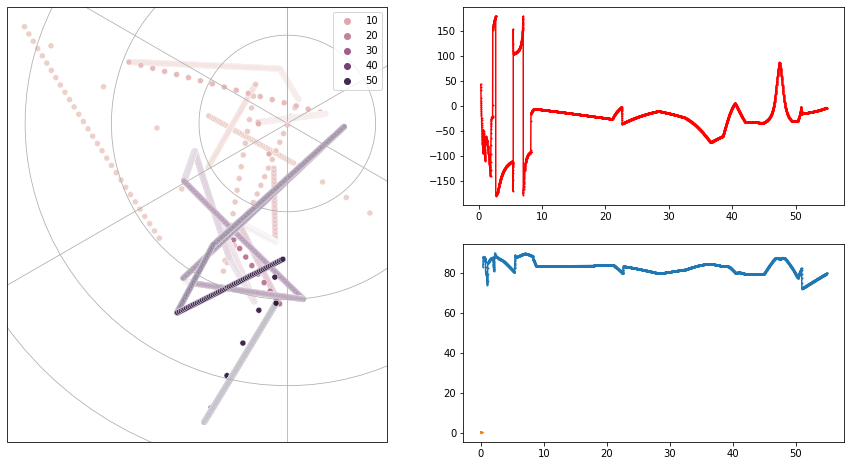

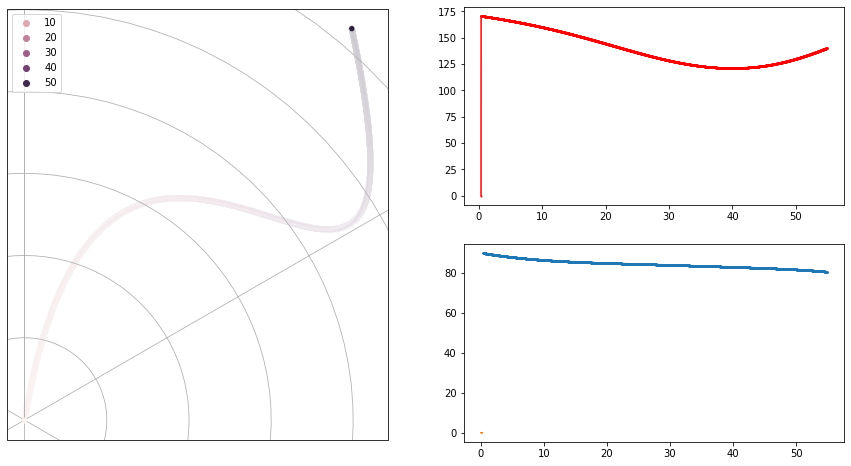

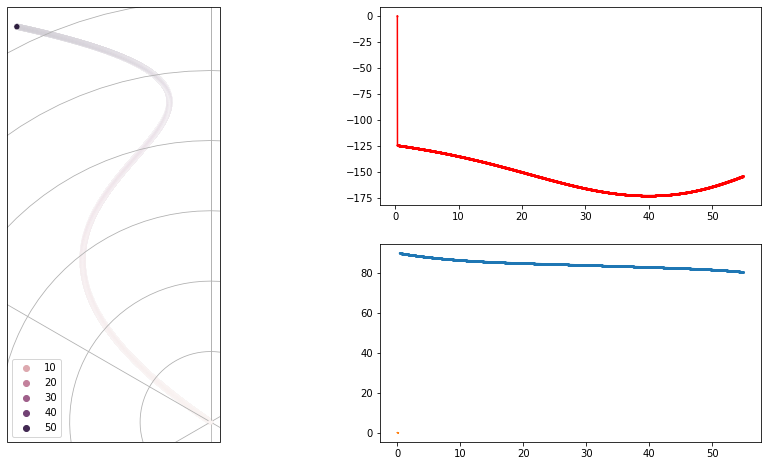

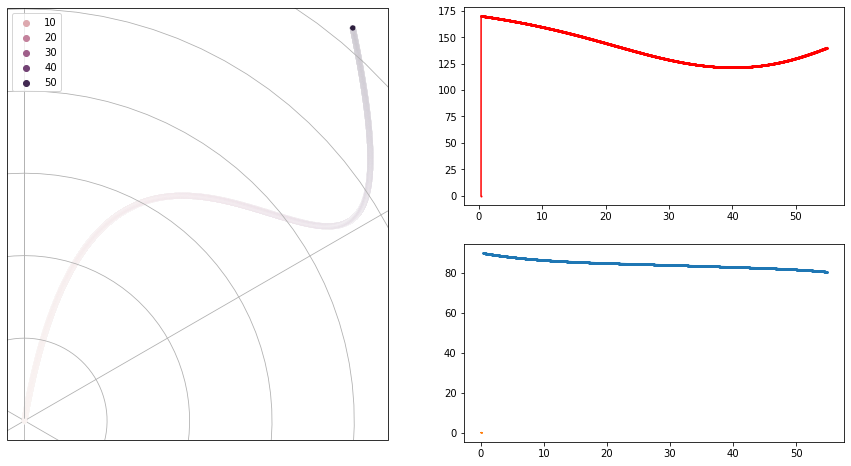

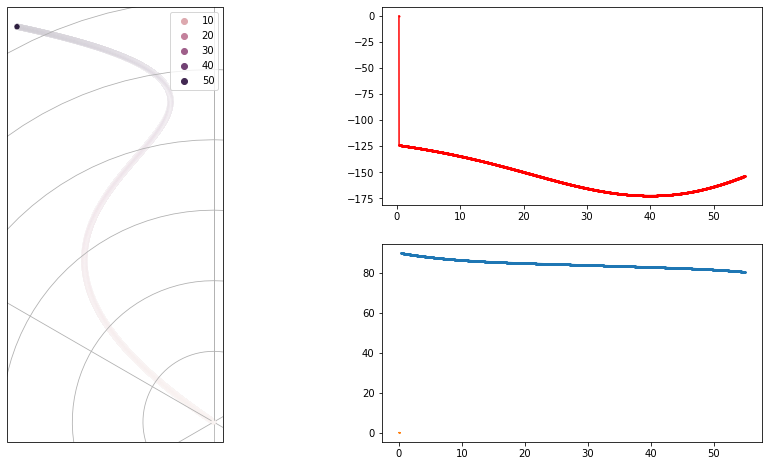

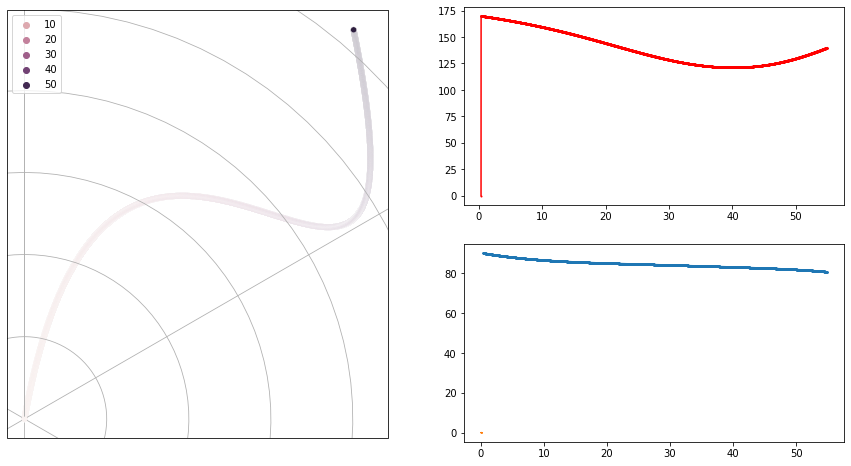

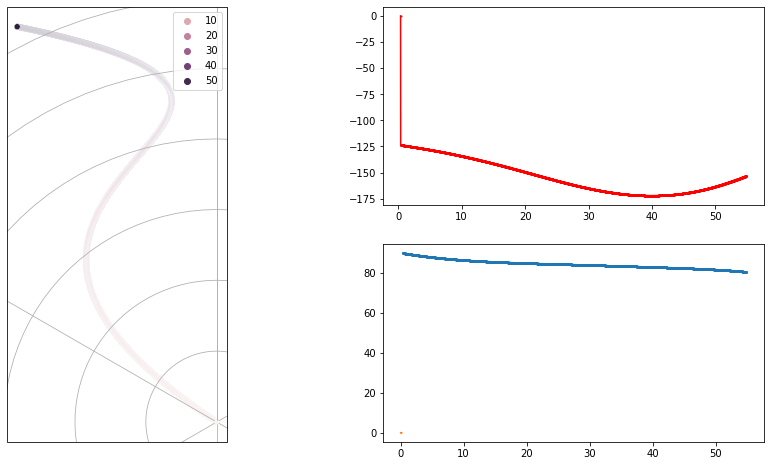

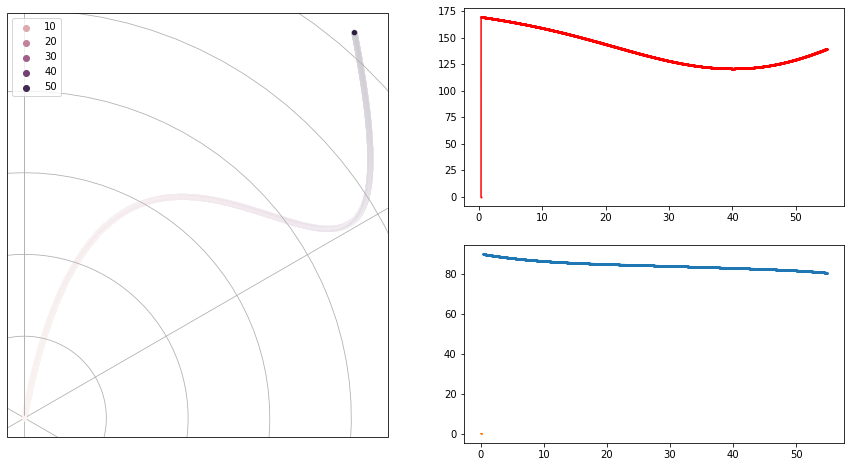

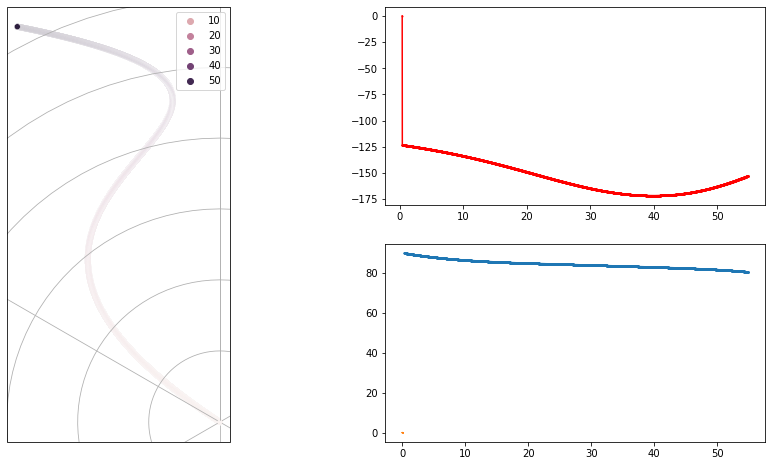

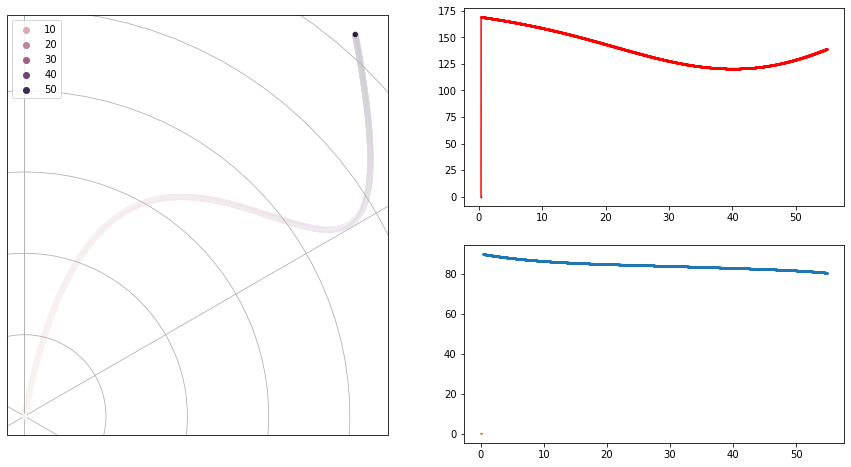

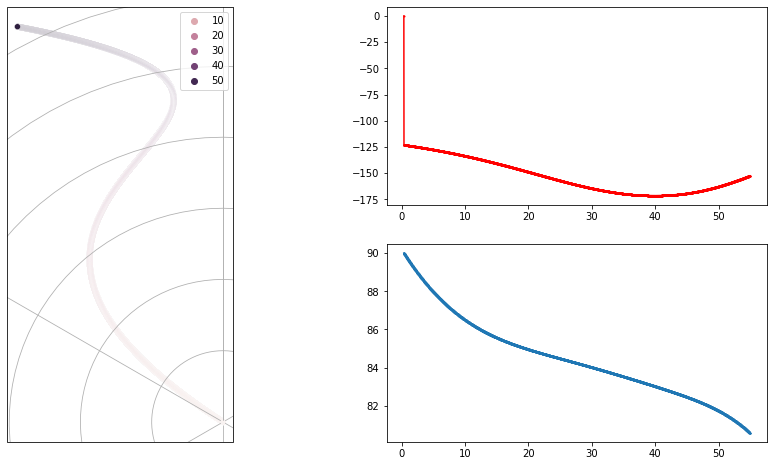

In [23]:
n_iter = 10
smoothing = 0.2 #0.2
precision = 0.001

# We first define a curve with the values we have in the dataset
curve_original = S2Curve(time_values=df.Time.values,
                         knot_values=df[['x', 'y', 'z']].values)

# and then we use it to construct a more finer curve
#time_steps = np.unique(np.sort(np.concatenate([np.arange(0, df.Time.max(), params.delta), df.Time.values])))
time_steps = np.arange(df.Time.min(), df.Time.max()-1, 0.01)
knot_steps = np.array([curve_original.evaluate(t,0) for t in time_steps])

curve = S2Curve(time_values=time_steps,
                knot_values=knot_steps)


all_curves = {}

for _ in range(n_iter):

    print(_)
    
    ### Unroll curve ###
    time, f_star, Rotation = unroll_curve(curve, delta_t=precision)
    # Update rotation and f* from unrolling
    curve.update_rotation(Rotation)
    curve.update_unroll(f_star)
    
    curve.plot()
    
    ### Unroll points ###
    D_star = unroll_points(curve, df.Time.values, df[['x','y','z']].values)
    print(D_star[0,:])
    ### Fit Splines ###
    spl_x = UnivariateSpline(df.Time.values, D_star[:,0], k=3, s=smoothing)

    spl_y = UnivariateSpline(df.Time.values, D_star[:,1], k=3, s=smoothing)
    
    X_ = spl_x(curve.time_values)
    Y_ = spl_y(curve.time_values)
    
    ### Update curve ###
    # for some reason this has been done with ones instead of zeros...
    #curve = roll_curve(curve.time_values, np.array([X_, Y_, np.ones(X_.shape[0])]).T)
    print("Rollig the curve")
    print(X_, Y_)
    curve = roll_curve(curve.time_values, np.array([X_, Y_, np.zeros(X_.shape[0])]).T, delta_t=precision)

    all_curves[_] = curve
    
curve.plot()

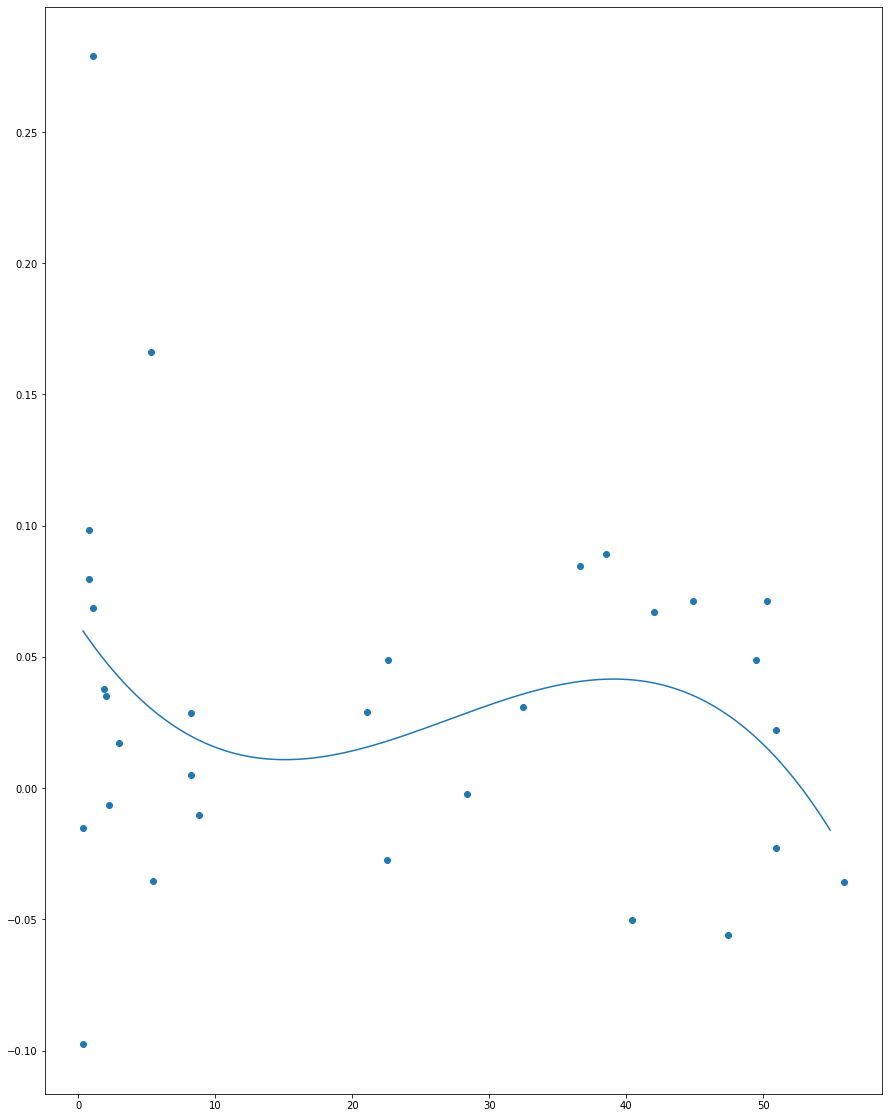

In [24]:
plt.scatter(df.Time.values, D_star[:,1] )
plt.plot(curve.time_values, Y_)

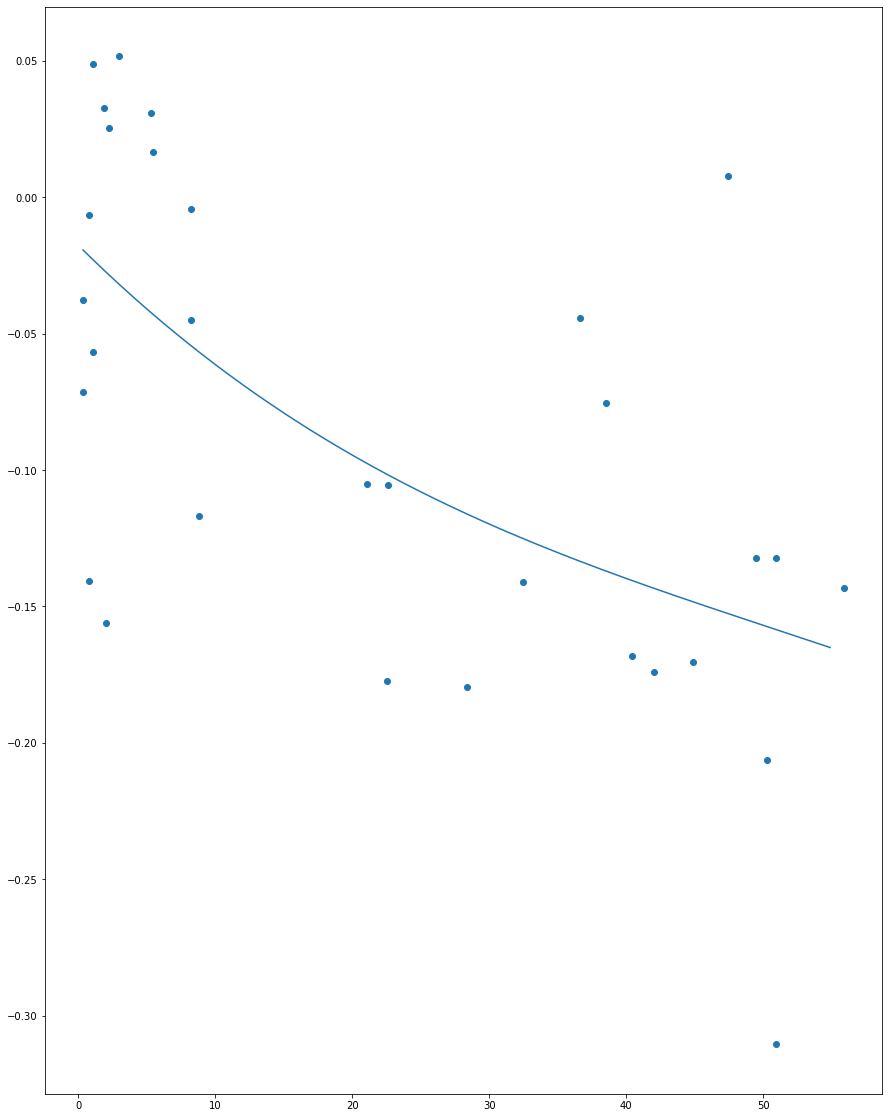

In [25]:
plt.scatter(df.Time.values, D_star[:,0] )
plt.plot(curve.time_values, X_)

<GeoAxesSubplot:xlabel='Lon', ylabel='Lat'>

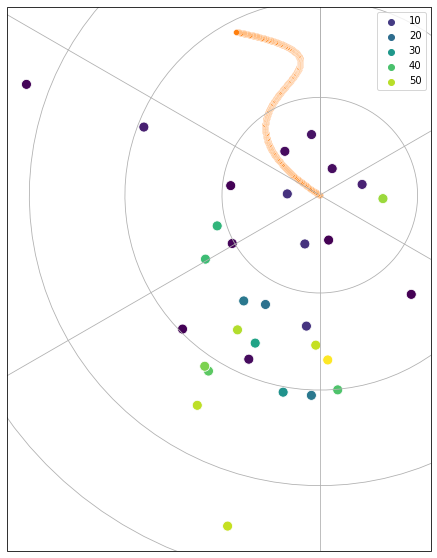

In [28]:
curve = all_curves[n_iter-3]

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=90))

#ax.coastlines()
ax.gridlines()

sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=100,
                palette="viridis",
                transform = ccrs.PlateCarree());

knot_values_sph = cart2sph(curve.knot_values, radians=False)[::10,:]

sns.scatterplot(ax=ax, x = knot_values_sph[:,0], y = knot_values_sph[:,1], 
                #hue = curve.time_values,
                transform = ccrs.PlateCarree())

In [ ]:
curve1 = all_curves[n_iter-1]
curve2 = all_curves[n_iter-2]

curve1.knot_values

In [ ]:
curve2.knot_values

In [ ]:
curve1.plot()

In [ ]:
curve2.plot()

In [ ]:
UnivariateSpline?

In [ ]:
Rotation[-5:]

In [ ]:
curve.evaluate(10, order=0)

In [ ]:
curve.time_values

In [ ]:
curve.evaluate(10)

In [ ]:
my_t = 10
idx_inf = np.max(np.where(curve.time_values - my_t <= 0.0))
idx_sup = np.min(np.where(curve.time_values - my_t > 0.0))
idx_inf, idx_sup

time_inf = curve.time_values[idx_inf]
time_sup = curve.time_values[idx_sup]
incremental = (my_t - time_inf) / (time_sup - time_inf)
time_inf, time_sup, incremental

In [ ]:
knot_inf = curve.knot_values[idx_inf, :]
knot_sup = curve.knot_values[idx_sup, :]
knot_inf, knot_sup

In [ ]:
slerp_interpolation(knot_inf, knot_sup, incremental, order=0, tmin=time_inf, tmax=time_sup)

In [ ]:
p1 = knot_inf, 
p2 = knot_sup

angle = np.arccos(np.dot(p1,p2))
    
( np.sin((1-incremental)*angle) * p1 + np.sin(incremental*angle) * p2 ) / np.sin(angle)

In [ ]:
np.dot(p1,p2)

In [ ]:
        assert (np.min(self.time_values) <= t) & (t <= np.max(self.time_values)), 'Age value is not inside the evaluation window.'
        
        idx_inf = np.max(np.where(self.time_values - t <= 0.0))
        idx_sup = np.min(np.where(self.time_values - t > 0.0))
        if idx_inf == idx_sup: 
            return self.knot_values[idx_inf, :]
            print('Evaluating self node.')
        assert idx_inf + 1 == idx_sup
        
        time_inf = self.time_values[idx_inf]
        time_sup = self.time_values[idx_sup]
        incremental = (t - time_inf) / (time_sup - time_inf)
        assert 0 <= incremental <= 1
        
        knot_inf = self.knot_values[idx_inf, :]
        knot_sup = self.knot_values[idx_sup, :]
                            
        return slerp_interpolation(knot_inf, knot_sup, incremental, order=order, tmin=time_inf, tmax=time_sup)

In [ ]:
curve.update_rotation(Rotation)
curve.update_unroll(f_star)

In [ ]:
D_star = unroll_points(curve, df.Time.values, df[['x','y','z']].values)

In [ ]:
from scipy.interpolate import UnivariateSpline

spl_x = UnivariateSpline(df.Time.values, D_star[:,0], k=3)
spl_x.set_smoothing_factor(0.5)

spl_y = UnivariateSpline(df.Time.values, D_star[:,1], k=3)
spl_y.set_smoothing_factor(0.5)

In [ ]:
X_ = spl_x(curve.time_values)
Y_ = spl_y(curve.time_values)

plt.plot(X_, Y_, '-')
plt.plot(curve.knot_values[:,0], curve.knot_values[:,1])
plt.scatter(D_star[:,0], D_star[:,1], marker='*')

In [ ]:
new_curve = roll_curve(curve.time_values, np.array([X_, Y_, np.ones(X_.shape[0])]).T)

In [ ]:
new_curve.plot()

In [ ]:
#curve.plot()
